In [4]:
import pandas as pd
import numpy as np
import scipy as sp
import re

from sklearn.preprocessing import LabelEncoder, MinMaxScaler, StandardScaler, RobustScaler
from sklearn.model_selection import RandomizedSearchCV, train_test_split

from bayes_opt import BayesianOptimization 

from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from catboost import Pool
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC

from sklearn.tree import DecisionTreeClassifier, plot_tree, export_graphviz
from sklearn.ensemble import  RandomForestClassifier, BaggingClassifier

import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

from sklearn.metrics import classification_report, accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve

In [5]:
# 데이터 불러오기 (제외할 컬럼 지정)
## "Unnamed: 0", "CustomerID" (유저 고유 번호) 
## "CallForwardingCalls" (모든 값이 0) 
train= pd.read_csv(r'C:\Users\simto\Documents\GIT\2024-08-05_Encore-4\day36\data\train.csv',encoding='CP949')

# 데이터 확인
train.head(5)


,CustomerID,Churn,MonthlyRevenue,MonthlyMinutes,TotalRecurringCharge,DirectorAssistedCalls,OverageMinutes,RoamingCalls,PercChangeMinutes,PercChangeRevenues,...,ReferralsMadeBySubscriber,IncomeGroup,OwnsMotorcycle,AdjustmentsToCreditRating,HandsetPrice,MadeCallToRetentionTeam,CreditRating,PrizmCode,Occupation,MaritalStatus
0,3000002,Yes,24.00,219.0,22.0,0.25,0.0,0.0,-157.0,-19.0,...,0,4,No,0,30,Yes,1-Highest,Suburban,Professional,No
1,3000010,Yes,16.99,10.0,17.0,0.00,0.0,0.0,-4.0,0.0,...,0,5,No,0,30,No,4-Medium,Suburban,Professional,Yes
2,3000014,No,38.00,8.0,38.0,0.00,0.0,0.0,-2.0,0.0,...,0,6,No,0,Unknown,No,3-Good,Town,Crafts,Yes
3,3000022,No,82.28,1312.0,75.0,1.24,0.0,0.0,157.0,8.1,...,0,6,No,0,10,No,4-Medium,Other,Other,No
4,3000026,Yes,17.14,0.0,17.0,0.00,0.0,0.0,0.0,-0.2,...,0,9,No,1,10,No,1-Highest,Other,Professional,Yes


### 1. 데이터 변환 - 카테고리 정수화, 스케일링

In [6]:
# 카테고리형 변수 정수로 변환 함수 정의
def convert_category_into_integer(df: pd.DataFrame, columns: list):
    label_encoders = {}
    for column in columns:
        label_encoder = LabelEncoder()
        df.loc[:, column] = label_encoder.fit_transform(df[column])
        df[column] = df[column].astype(int)
        label_encoders.update({column: label_encoder})
    
    return df, label_encoders

In [7]:
# 카테고리 변수 정수로 변환
train, _ = convert_category_into_integer(train,
    ('Churn', 
     'HandsetRefurbished', 
     'HandsetWebCapable',
     'TruckOwner',
     "RVOwner",                     
    "Homeownership",              
    "BuysViaMailOrder",            
    "RespondsToMailOffers",       
    "OptOutMailings",              
    "NonUSTravel" ,                
    "OwnsComputer" ,              
    "HasCreditCard" ,     
    "NewCellphoneUser",           
    "NotNewCellphoneUser",    
    "OwnsMotorcycle",
    "HandsetPrice",             
    "MadeCallToRetentionTeam", 
    "PrizmCode",               
    "Occupation", 
    "MaritalStatus",
    'ServiceArea', 
    'ChildrenInHH' 
))

In [8]:
print(train.describe(include='all'))

          CustomerID         Churn  MonthlyRevenue  MonthlyMinutes  \
count   5.104700e+04  51047.000000    50891.000000    50891.000000   
unique           NaN           NaN             NaN             NaN   
top              NaN           NaN             NaN             NaN   
freq             NaN           NaN             NaN             NaN   
mean    3.201957e+06      0.288185       58.834492      525.653416   
std     1.169056e+05      0.452922       44.507336      529.871063   
min     3.000002e+06      0.000000       -6.170000        0.000000   
25%     3.100632e+06      0.000000       33.610000      158.000000   
50%     3.201534e+06      0.000000       48.460000      366.000000   
75%     3.305376e+06      1.000000       71.065000      723.000000   
max     3.399994e+06      1.000000     1223.380000     7359.000000   

        TotalRecurringCharge  DirectorAssistedCalls  OverageMinutes  \
count           50891.000000           50891.000000    50891.000000   
unique           

In [9]:
# 스케일링 함수 정의
def scale_data(train, scaler_type='standard', target_col='Churn'):
    """
    데이터셋을 주어진 스케일러로 변환하는 함수.
    
    Parameters:
    - train: 스케일링할 데이터프레임
    - scaler_type: 사용할 스케일러 ('minmax', 'standard', 'robust')
    - target_col: 타겟 컬럼명 (예: 'Churn')
    
    Returns:
    - 스케일링된 데이터프레임
    """
    # 스케일러 선택
    if scaler_type == 'minmax':
        scaler = MinMaxScaler()
    elif scaler_type == 'robust':
        scaler = RobustScaler()
    else:
        scaler = StandardScaler()

    # 타겟 컬럼을 제외한 나머지 데이터 스케일링
    features = train.drop(columns=[target_col])
    target = train[target_col]

    # 스케일러를 사용해 변환
    scaled_features = scaler.fit_transform(features)

    # 변환된 데이터프레임 재구성
    scaled_train = pd.DataFrame(scaled_features, columns=features.columns)
    scaled_train[target_col] = target.values
    
    return scaled_train


In [10]:
# MinMaxScaler/StandardScaler/RobustScaler를 사용하는 경우("minmax", "standard", "robust")
train_scaled = scale_data(train, scaler_type='standard')
train_scaled.describe()

ValueError: could not convert string to float: '1-Highest'

In [20]:
# 데이터 셋 분리
train_scaled, test_scaled = train_test_split(train_scaled, test_size=0.2, random_state=0)
train_scaled, valid_scaled = train_test_split(train_scaled, test_size=len(test_scaled)/len(train_scaled), random_state=0)


In [21]:
# 특성 이름에 JSON 특수 문자 제거
def clean_column_names(df):
    df.columns = [re.sub(r'[^a-zA-Z0-9_]', '_', col) for col in df.columns]
    return df

train_scaled = clean_column_names(train_scaled)
test_scaled = clean_column_names(test_scaled)

# 모델 리스트와 하이퍼파라미터 범위 설정
models = {
    "Decision Tree": (DecisionTreeClassifier(), {
        'max_depth': [None, 2, 5, 10, 15, 20],
        'min_samples_split': np.arange(2, 11)
    }),
    "Random Forest": (RandomForestClassifier(), {
        'n_estimators': np.random.randint(50, 500, size=10),
        'max_depth': [None, 2, 5, 10, 15, 20],
        'min_samples_split': np.arange(2, 11)
    }),
    # "SVM": (SVC(probability=True), { # SVM 제외 recall, Precision, Recall, F1- score가 표본 1000개로 돌렸을 때 0 나오고, 결과나오는데 시간이 오래 걸림림)
    #     'C': np.logspace(-3, 3, 7),
    #     'kernel': ['linear', 'rbf']
    #  }),
    "XGBoost": (XGBClassifier(eval_metric='logloss', objective='binary:logistic'), {
        'n_estimators': np.random.randint(50, 500, size=10),
        'learning_rate': np.random.uniform(1e-5, 1e-1, size=10),
    }),
    "LightGBM": (LGBMClassifier(class_weight='balanced',verbose = 0), {  # 모델 초기화 시 클래스 가중치 추가
        'n_estimators': np.random.randint(50, 500, size=10),
        'learning_rate': np.random.uniform(1e-5, 1e-1, size=10),

    }),
    "CatBoost": (CatBoostClassifier(verbose=0), {
        'iterations': np.random.randint(50, 500, size=10),
        'learning_rate': np.random.uniform(1e-5, 1e-1, size=10),
    }),
}

results = {}

# 모델 학습 및 평가
for model_name, (model, params) in models.items():
    random_search = RandomizedSearchCV(
        model,
        params,
        scoring='accuracy',
        random_state=0,
        n_iter=10,
        n_jobs=-1  # 여러 CPU를 사용하도록 설정
    )
    
    random_search.fit(train_scaled.drop(columns=['Churn']), train_scaled['Churn'])
    
    best_param = random_search.best_params_
    print(f"Best parameters from Random Search for {model_name}: {best_param}")
    
    best_model = random_search.best_estimator_
    y_pred_test = best_model.predict(test_scaled.drop(columns=["Churn"]))
    
    print(f"Classification Report for Test Data {model_name}:")
    print(classification_report(test_scaled["Churn"], y_pred_test))
    
    results[model_name] = best_model

# 예측 결과를 DataFrame으로 정리
results_list = []

for model_name, model in results.items():
    y_pred_test = model.predict(test_scaled.drop(columns=["Churn"]))
    accuracy = accuracy_score(test_scaled["Churn"], y_pred_test)
    precision = precision_score(test_scaled["Churn"], y_pred_test, zero_division=0)
    recall = recall_score(test_scaled["Churn"], y_pred_test)
    f1 = f1_score(test_scaled["Churn"], y_pred_test)

    results_list.append({
        "Model": model_name,
        "Accuracy": accuracy,
        "Precision": precision,
        "Recall": recall,
        "F1 Score": f1
    })

results_df = pd.DataFrame(results_list)

print("\nModel Evaluation Metrics Summary:")
print(results_df)


Best parameters from Random Search for Decision Tree: {'min_samples_split': 4, 'max_depth': 2}
Classification Report for Test Data Decision Tree:
              precision    recall  f1-score   support

           0       0.71      1.00      0.83      7208
           1       0.00      0.00      0.00      2914

    accuracy                           0.71     10122
   macro avg       0.36      0.50      0.42     10122
weighted avg       0.51      0.71      0.59     10122



c:\ProgramData\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\ProgramData\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\ProgramData\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Best parameters from Random Search for Random Forest: {'n_estimators': 398, 'min_samples_split': 6, 'max_depth': 20}
Classification Report for Test Data Random Forest:
              precision    recall  f1-score   support

           0       0.72      0.99      0.83      7208
           1       0.63      0.06      0.11      2914

    accuracy                           0.72     10122
   macro avg       0.68      0.52      0.47     10122
weighted avg       0.70      0.72      0.63     10122

Best parameters from Random Search for XGBoost: {'n_estimators': 334, 'learning_rate': 0.04681872044674364}
Classification Report for Test Data XGBoost:
              precision    recall  f1-score   support

           0       0.74      0.94      0.83      7208
           1       0.56      0.17      0.26      2914

    accuracy                           0.72     10122
   macro avg       0.65      0.56      0.55     10122
weighted avg       0.69      0.72      0.67     10122

Best parameters from Rand

## 3. 모델 결과 종합

Model Evaluation Metrics for Decision Tree:
Accuracy: 0.7121
Precision: 0.0000
Recall: 0.0000
F1 Score: 0.0000
ROC AUC: 0.6144

Model Evaluation Metrics for Random Forest:
Accuracy: 0.7197
Precision: 0.6323
Recall: 0.0631
F1 Score: 0.1148
ROC AUC: 0.6743

Model Evaluation Metrics for XGBoost:
Accuracy: 0.7222
Precision: 0.5567
Recall: 0.1719
F1 Score: 0.2627
ROC AUC: 0.6741

Model Evaluation Metrics for LightGBM:
Accuracy: 0.6476
Precision: 0.4121
Recall: 0.5251
F1 Score: 0.4617
ROC AUC: 0.6657

Model Evaluation Metrics for CatBoost:
Accuracy: 0.7240
Precision: 0.5906
Recall: 0.1342
F1 Score: 0.2187
ROC AUC: 0.6811



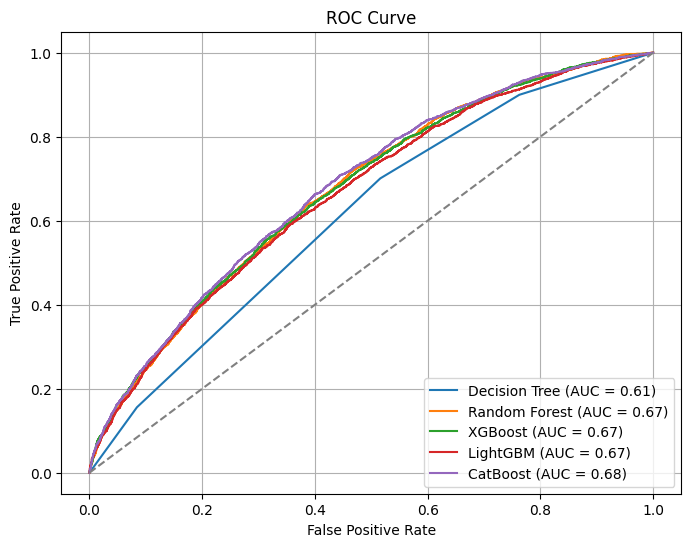

In [23]:
# 모델 리스트와 평가할 모델 설정
models = {
    "Decision Tree": results["Decision Tree"],
    "Random Forest": results["Random Forest"],
    #"SVM": results["SVM"], 
    "XGBoost": results["XGBoost"],
    "LightGBM": results["LightGBM"],  
    "CatBoost": results["CatBoost"]
}

# 평가 지표 저장용 딕셔너리
metrics = {}

# 각 모델의 예측 및 예측 확률 계산
for model_name, model in models.items():
    y_pred_test = model.predict(test_scaled.drop(columns=["Churn"]))
    y_pred_proba_test = model.predict_proba(test_scaled.drop(columns=["Churn"]))[:, 1]
    
    metrics[model_name] = {
        "accuracy": accuracy_score(test_scaled["Churn"], y_pred_test),
        "precision": precision_score(test_scaled["Churn"], y_pred_test, zero_division=0),
        "recall": recall_score(test_scaled["Churn"], y_pred_test),
        "f1": f1_score(test_scaled["Churn"], y_pred_test),
        "roc_auc": roc_auc_score(test_scaled["Churn"], y_pred_proba_test),
        "fpr": roc_curve(test_scaled["Churn"], y_pred_proba_test)[0],
        "tpr": roc_curve(test_scaled["Churn"], y_pred_proba_test)[1],
        "roc_auc_value": roc_auc_score(test_scaled["Churn"], y_pred_proba_test)
    }

# 평가 지표 출력
for model_name, scores in metrics.items():
    print(f"Model Evaluation Metrics for {model_name}:")
    print(f"Accuracy: {scores['accuracy']:.4f}")
    print(f"Precision: {scores['precision']:.4f}")
    print(f"Recall: {scores['recall']:.4f}")
    print(f"F1 Score: {scores['f1']:.4f}")
    print(f"ROC AUC: {scores['roc_auc']:.4f}\n")

# ROC Curve 시각화
plt.figure(figsize=(8, 6))
for model_name, scores in metrics.items():
    plt.plot(scores['fpr'], scores['tpr'], label=f'{model_name} (AUC = {scores["roc_auc_value"]:.2f})')

plt.plot([0, 1], [0, 1], color='grey', linestyle='--')  # 대각선
plt.title('ROC Curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='lower right')
plt.grid()
plt.show()



Feature Importance for Decision Tree Model:
                 Feature  Importance
26  CurrentEquipmentDays    0.718216
20       MonthsInService    0.281784


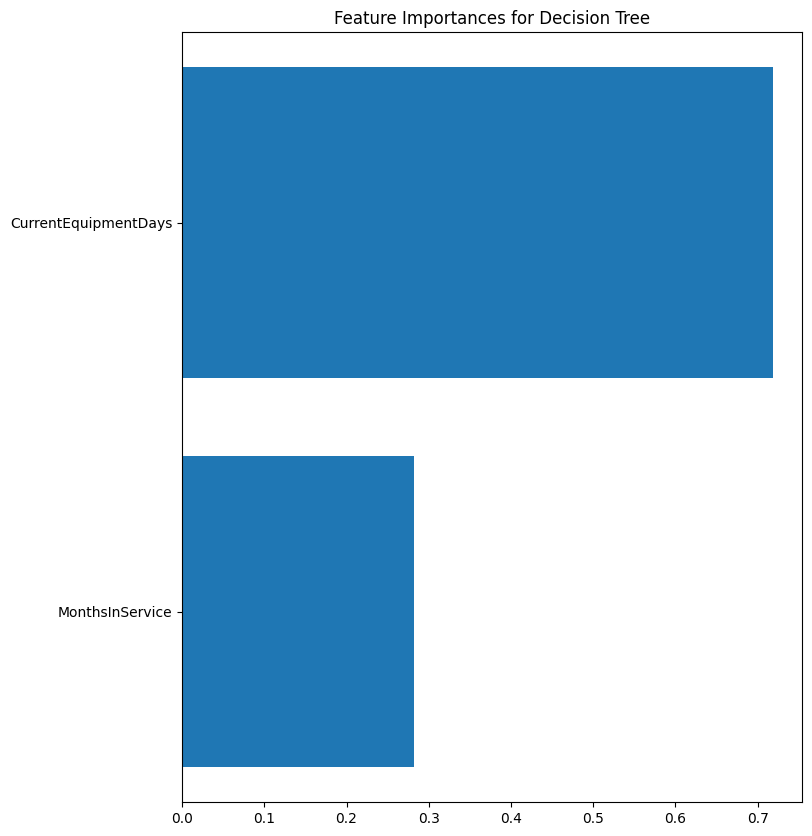


Feature Importance for Random Forest Model:
                      Feature  Importance
26       CurrentEquipmentDays    0.063745
6           PercChangeMinutes    0.050440
20            MonthsInService    0.046629
1              MonthlyMinutes    0.046055
23                ServiceArea    0.043790
0              MonthlyRevenue    0.041771
7          PercChangeRevenues    0.041663
16             PeakCallsInOut    0.038489
17          OffPeakCallsInOut    0.037328
13              ReceivedCalls    0.035833
10            UnansweredCalls    0.035593
14              OutboundCalls    0.033641
18        DroppedBlockedCalls    0.031085
2        TotalRecurringCharge    0.030325
8                DroppedCalls    0.028877
27                     AgeHH1    0.027882
4              OverageMinutes    0.027797
15               InboundCalls    0.026877
9                BlockedCalls    0.025140
28                     AgeHH2    0.020901
46                IncomeGroup    0.019941
3       DirectorAssistedCalls  

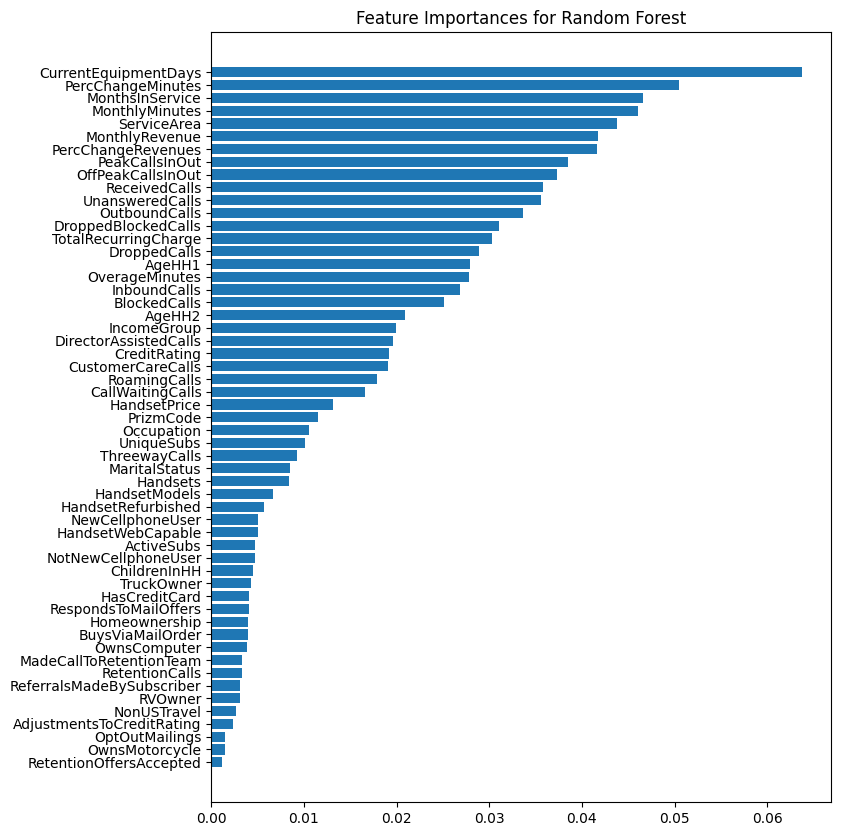


Feature Importance for XGBoost Model:
                      Feature  Importance
26       CurrentEquipmentDays    0.043971
41             RetentionCalls    0.039480
20            MonthsInService    0.038218
30         HandsetRefurbished    0.029409
31          HandsetWebCapable    0.026524
22                 ActiveSubs    0.025868
1              MonthlyMinutes    0.023871
6           PercChangeMinutes    0.023741
21                 UniqueSubs    0.022193
2        TotalRecurringCharge    0.020890
4              OverageMinutes    0.020888
51               CreditRating    0.020364
16             PeakCallsInOut    0.019615
25              HandsetModels    0.018574
11          CustomerCareCalls    0.018376
7          PercChangeRevenues    0.018276
8                DroppedCalls    0.017939
0              MonthlyRevenue    0.017865
28                     AgeHH2    0.017844
18        DroppedBlockedCalls    0.017749
27                     AgeHH1    0.017696
17          OffPeakCallsInOut    0.01

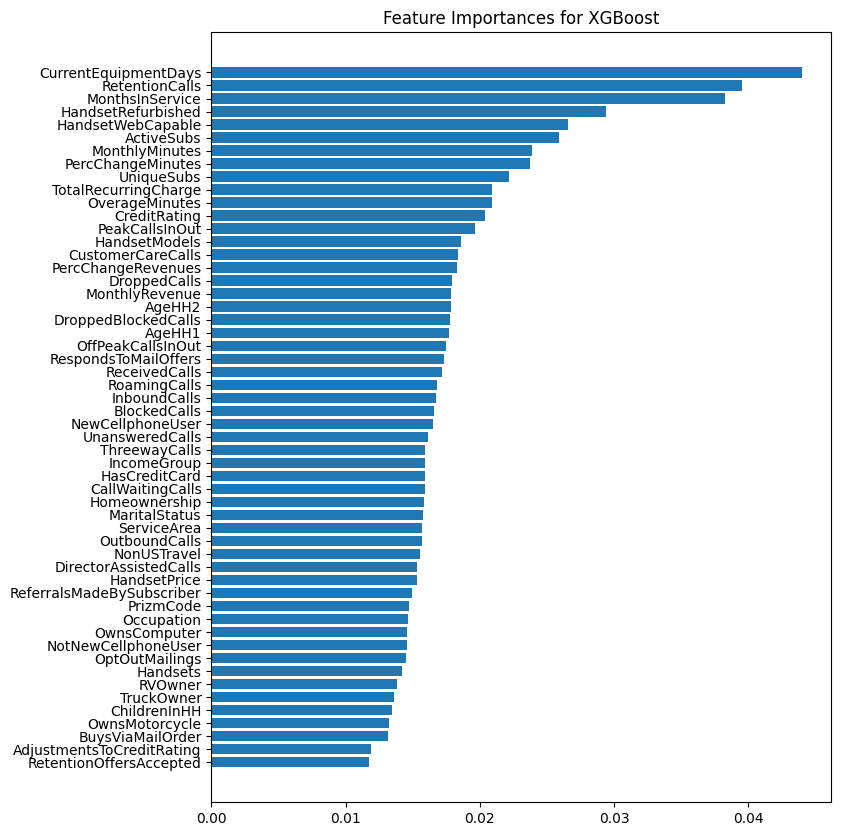


Feature Importance for LightGBM Model:
                      Feature  Importance
6           PercChangeMinutes         663
23                ServiceArea         622
7          PercChangeRevenues         583
1              MonthlyMinutes         582
26       CurrentEquipmentDays         570
0              MonthlyRevenue         501
17          OffPeakCallsInOut         494
20            MonthsInService         437
10            UnansweredCalls         423
16             PeakCallsInOut         422
13              ReceivedCalls         416
14              OutboundCalls         404
2        TotalRecurringCharge         387
18        DroppedBlockedCalls         354
8                DroppedCalls         335
4              OverageMinutes         328
15               InboundCalls         315
27                     AgeHH1         310
9                BlockedCalls         276
28                     AgeHH2         244
11          CustomerCareCalls         237
5                RoamingCalls       

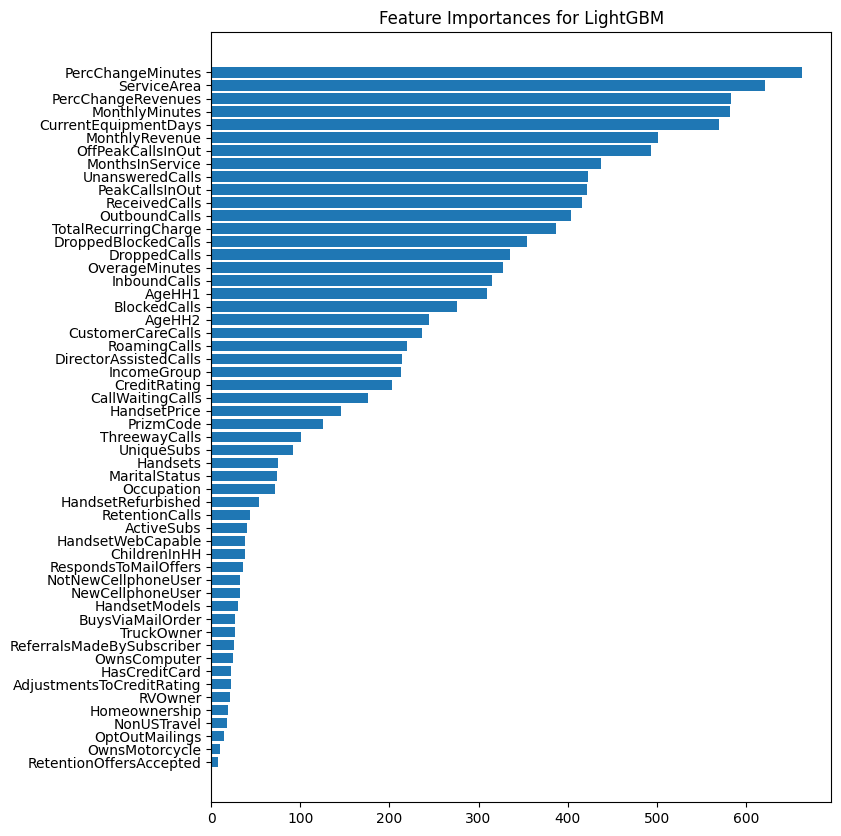


Feature Importance for CatBoost Model:
                      Feature  Importance
20            MonthsInService   10.284273
26       CurrentEquipmentDays    8.222387
6           PercChangeMinutes    7.596062
1              MonthlyMinutes    7.050564
2        TotalRecurringCharge    4.552223
23                ServiceArea    4.028508
7          PercChangeRevenues    3.851206
51               CreditRating    3.213506
0              MonthlyRevenue    2.982602
17          OffPeakCallsInOut    2.876631
27                     AgeHH1    2.682815
4              OverageMinutes    2.590835
16             PeakCallsInOut    2.290284
8                DroppedCalls    2.178898
11          CustomerCareCalls    2.152382
13              ReceivedCalls    2.143648
15               InboundCalls    1.981964
9                BlockedCalls    1.943414
18        DroppedBlockedCalls    1.868618
21                 UniqueSubs    1.799211
14              OutboundCalls    1.791233
10            UnansweredCalls    1.7

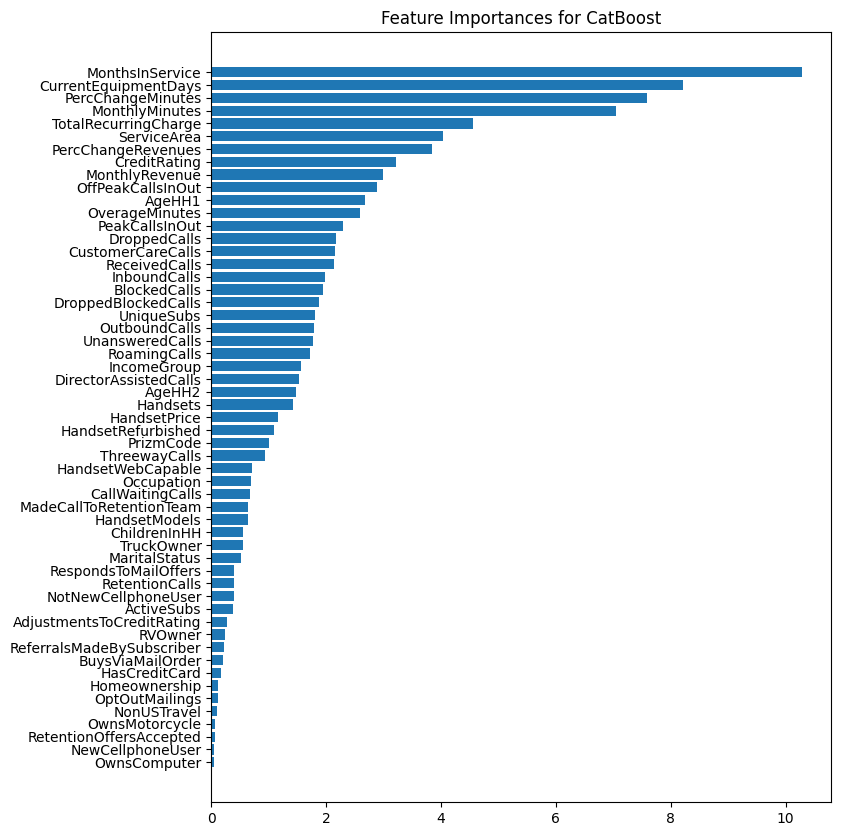

In [32]:
# 범주형 컬럼 추출
categorical_columns = train.select_dtypes(include=['object']).columns.tolist()

# CatBoost에서 사용할 Pool 임포트
from catboost import Pool

# 모델별 변수 중요도 확인
models = {
    "Decision Tree": results["Decision Tree"],
    "Random Forest": results["Random Forest"],
    "XGBoost": results["XGBoost"],
    "LightGBM": results["LightGBM"],
    "CatBoost": results["CatBoost"]
}

# 모든 모델에 대한 변수 중요도 시각화 및 정렬된 중요도 출력
for model_name, model in models.items():
    if model_name != "CatBoost":  # CatBoost는 Pool을 사용해서 별도 처리
        if hasattr(model, 'feature_importances_'):  # feature_importances_가 있는 경우
            print(f"\nFeature Importance for {model_name} Model:")
            
            # 변수 중요도 계산
            importances = model.feature_importances_
            importance_df = pd.DataFrame({
                'Feature': test_scaled.drop(columns=["Churn"]).columns,
                'Importance': importances
            })

            # 0인 값을 제외하고 정렬
            importance_df = importance_df[importance_df['Importance'] > 0].sort_values(by='Importance', ascending=False)
            
            # 중요도 출력
            print(importance_df)
            
            # 변수 중요도 시각화
            plt.figure(figsize=(8, 10))
            plt.barh(importance_df['Feature'], importance_df['Importance'])
            plt.title(f"Feature Importances for {model_name}")
            plt.gca().invert_yaxis()  # 중요도가 높은 순으로 상단에 오도록
            plt.show()
        else:
            print(f"{model_name} does not support feature importances.")
    
    else:
        # CatBoost 모델의 변수 중요도 시각화 및 정렬된 중요도 출력
        print(f"\nFeature Importance for {model_name} Model:")
        
        # Pool 객체 생성 (categorical_columns는 범주형 변수 리스트)
        catboost_data = Pool(test_scaled.drop(columns=["Churn"]), label=test_scaled["Churn"], cat_features=categorical_columns)
        importances = model.get_feature_importance(catboost_data)
        
        # 변수 중요도 계산
        importance_df = pd.DataFrame({
            'Feature': test_scaled.drop(columns=["Churn"]).columns,
            'Importance': importances
        })

        # 0인 값을 제외하고 정렬
        importance_df = importance_df[importance_df['Importance'] > 0].sort_values(by='Importance', ascending=False)
        
        # 중요도 출력
        print(importance_df)
        
        # 변수 중요도 시각화
        plt.figure(figsize=(8, 10))
        plt.barh(importance_df['Feature'], importance_df['Importance'])
        plt.title(f"Feature Importances for {model_name}")
        plt.gca().invert_yaxis()  # 중요도가 높은 순으로 상단에 오도록
        plt.show()
